In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import pandas as pd
import numpy as np
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


Using TensorFlow backend.


### Control Variables

In [3]:
np.random.seed(42) 
n_steps = 50

### Support Functions

In [4]:
# split a multivariate sequence into samples
# source: Jason Brownlee - How to Develop LSTM Models for Time Series Forecasting
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


### Absolute Price LSTM

Create a Bidrectional Stacked LSTM for predicting the next day closing price.

In [5]:
df = pd.read_pickle("sp500.pickle")

# choose the correct Y
df = df.drop('Target+', axis=1)
df = df.drop('Target_', axis=1)
df = df.astype('float64')

# report initial results
print("Shape of pandas train      set: {}".format(df.loc["2010-01-01":"2017-01-01"].shape))
print("Shape of pandas validation set: {}".format(df.loc["2017-01-01":"2018-01-01"].shape))
print("Shape of pandas test       set: {}\n".format(df.loc["2018-01-01":"2019-01-01"].shape))

# find split coordinates
train_size = df.loc["2010-01-01":"2017-01-01"].shape[0]
validation_size = df.loc["2017-01-01":"2018-01-01"].shape[0]
test_size = df.loc["2018-01-01":"2019-01-01"].shape[0]

print("Size of train              set: {}".format(train_size))
print("Size of validation         set: {}".format(validation_size))
print("Size of test               set: {}\n".format(test_size))

# scale entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

# define sets
train = dataset[0:train_size]
validation = dataset[train_size : train_size + validation_size]
test  = dataset[train_size + validation_size: ]

print("Shape of numpy train       set: {}".format(train.shape))
print("Shape of numpy validation  set: {}".format(validation.shape))
print("Shape of numpy test        set: {}".format(test.shape))

# print(scaler.inverse_transform(test)[0] - 
# df.loc["2018-01-01":"2019-01-01"].values[0])

Shape of pandas train      set: (1777, 22)
Shape of pandas validation set: (253, 22)
Shape of pandas test       set: (254, 22)

Size of train              set: 1777
Size of validation         set: 253
Size of test               set: 254

Shape of numpy train       set: (1777, 22)
Shape of numpy validation  set: (253, 22)
Shape of numpy test        set: (254, 22)


In [6]:
# How many time steps back? - CRITICAL
print("Number of Steps back:", n_steps)

# convert into X and y
X_train, y_train = split_sequences(train, n_steps)
X_validation, y_validation = split_sequences(validation, n_steps)
X_test,  y_test = split_sequences(test, n_steps)

validation_data=(X_validation, y_validation)

# define number of features into the model - CRITICAL
n_features = X_train.shape[2]
print("Number of Features:", n_features)

# verify shapes of model inputs
print("Train shape       :", X_train.shape, y_train.shape)
print("Validation shape  :", X_validation.shape, y_validation.shape)
print("Test shape        :", X_test.shape, y_test.shape)


Number of Steps back: 50
Number of Features: 21
Train shape       : (1728, 50, 21) (1728,)
Validation shape  : (204, 50, 21) (204,)
Test shape        : (205, 50, 21) (205,)


In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(200, return_sequences=True, activation='relu'), input_shape=(n_steps, n_features)))
# model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))

# model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# fit model
%time history=model.fit(X_train, y_train, \
                        validation_data=validation_data, \
                        epochs=200, batch_size=10, verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1728 samples, validate on 204 samples
Epoch 1/200
 - 16s - loss: 0.0040 - acc: 5.7870e-04 - val_loss: 3.4600e-04 - val_acc: 0.0000e+00
Epoch 2/200
 - 15s - loss: 5.0530e-05 - acc: 5.7870e-04 - val_loss: 4.8188e-04 - val_acc: 0.0000e+00
Epoch 3/200
 - 15s - loss: 2.2618e-05 - acc: 5.7870e-04 - val_loss: 1.4798e-04 - val_acc: 0.0000e+00
Epoch 4/200
 - 15s - loss: 1.4976e-05 - acc: 5.7870e-04 - val_loss: 6.6324e-04 - val_acc: 0.0000e+00
Epoch 5/200
 - 15s - loss: 1.7868e-05 - acc: 5.7870e-04 - val_loss: 3.5777e-04 - val_acc: 0.0000e+00
Epoch 6/200
 - 15s - loss: 2.7413e-05 - acc: 5.7870e-04 - val_loss: 3.5718e-05 - val_acc: 0.0000e+00
Epoch 7/200
 - 15s - loss: 1.7288e-05 - acc: 5.7870e-04 - val_loss: 1.1900e-04 - val_acc: 0.0000e+00
Epoch 8/200
 - 15s - loss: 2.2207e-05 - acc: 5.7870e-04 - val_loss: 3.3589e-05 - val_acc: 0.0000e+00
Epoch 9/200
 - 15s - loss: 1.

Epoch 77/200
 - 15s - loss: 3.3975e-06 - acc: 5.7870e-04 - val_loss: 5.0305 - val_acc: 0.0000e+00
Epoch 78/200
 - 15s - loss: 6.2631e-06 - acc: 5.7870e-04 - val_loss: 1.6684e-04 - val_acc: 0.0000e+00
Epoch 79/200
 - 15s - loss: 1.4157e-05 - acc: 5.7870e-04 - val_loss: 1.4754e-04 - val_acc: 0.0000e+00
Epoch 80/200
 - 15s - loss: 4.3060e-06 - acc: 5.7870e-04 - val_loss: 1.0998e-04 - val_acc: 0.0000e+00
Epoch 81/200
 - 15s - loss: 1.7893e-06 - acc: 5.7870e-04 - val_loss: 2.1156e-04 - val_acc: 0.0000e+00
Epoch 82/200
 - 15s - loss: 6.8605e-06 - acc: 5.7870e-04 - val_loss: 5.8300e-05 - val_acc: 0.0000e+00
Epoch 83/200
 - 15s - loss: 4.9467e-06 - acc: 5.7870e-04 - val_loss: 34.3412 - val_acc: 0.0000e+00
Epoch 84/200
 - 15s - loss: 3.4705e-06 - acc: 5.7870e-04 - val_loss: 1.5286e-05 - val_acc: 0.0000e+00
Epoch 85/200
 - 15s - loss: 5.4518e-06 - acc: 5.7870e-04 - val_loss: 1.0435e-04 - val_acc: 0.0000e+00
Epoch 86/200
 - 15s - loss: 2.6858e-06 - acc: 5.7870e-04 - val_loss: 5.8111e-06 - val_acc

Epoch 158/200
 - 15s - loss: 1.1432e-05 - acc: 5.7870e-04 - val_loss: 4.7995e-05 - val_acc: 0.0000e+00
Epoch 159/200
 - 15s - loss: 1.3407e-06 - acc: 5.7870e-04 - val_loss: 2.4043e-06 - val_acc: 0.0000e+00
Epoch 160/200
 - 15s - loss: 1.2640e-06 - acc: 5.7870e-04 - val_loss: 7.7358e-06 - val_acc: 0.0000e+00
Epoch 161/200
 - 15s - loss: 1.1626e-06 - acc: 5.7870e-04 - val_loss: 9.4631e-07 - val_acc: 0.0000e+00
Epoch 162/200
 - 15s - loss: 1.1268e-06 - acc: 5.7870e-04 - val_loss: 3.6319e-06 - val_acc: 0.0000e+00
Epoch 163/200
 - 15s - loss: 3.3019e-06 - acc: 5.7870e-04 - val_loss: 2.6613e-06 - val_acc: 0.0000e+00
Epoch 164/200
 - 15s - loss: 2.5265e-06 - acc: 5.7870e-04 - val_loss: 1.8116e-06 - val_acc: 0.0000e+00
Epoch 165/200
 - 15s - loss: 1.5759e-06 - acc: 5.7870e-04 - val_loss: 3.0653e-06 - val_acc: 0.0000e+00
Epoch 166/200
 - 15s - loss: 2.3562e-06 - acc: 5.7870e-04 - val_loss: 5.9429e-06 - val_acc: 0.0000e+00
Epoch 167/200
 - 15s - loss: 1.4997e-06 - acc: 5.7870e-04 - val_loss: 2.4

In [8]:
yhat = model.predict(X_test)
a = np.zeros((205,21))
print("yhat shape is {}".format(yhat.shape))
pred = np.concatenate((a, yhat),  axis=1)
pred = scaler.inverse_transform(pred)
pred = pred[:,-1]
print("pred shape is {}".format(pred.shape))
pred[0]

yhat shape is (205, 1)
pred shape is (205,)


2772.4988123755866

In [9]:
print("yhat shape is {}".format(y_test.shape))
new_y = y_test.reshape(y_test.shape[0],1)
print("new_y shape is {}".format(new_y.shape))
y_pred = np.concatenate((a, new_y),  axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,-1]
y_pred[0]

yhat shape is (205,)
new_y shape is (205, 1)


2783.02001953125

In [10]:
testScore = mean_squared_error(pred, y_pred)
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 330.09 RMSE


In [11]:
# make predictions
# trainPredict = model.predict(X_train)
# testPredict = model.predict(X_test)
# print(trainPredict.shape)

# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([y_train])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([y_test])

# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

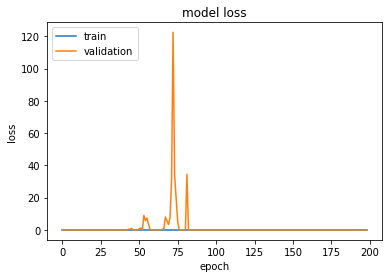

In [12]:
# summarize history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# loss = [min(x, 1000) for x in loss]
# val_loss = [min(x, 1000) for x in val_loss]

plt.plot(loss[1:])
plt.plot(val_loss[1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# acc = [min(x, 1000) for x in acc]
# val_acc = [min(x, 1000) for x in val_acc]

plt.plot(y_pred[1:])
plt.plot(pred)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
Epoch 149/200
plt.show()


In [ ]:
# 